### Team members

##### Chirag Bhuvaneshwara
* 2571703
* s8chbhuv@stud.uni-saarland.de

##### Priyasha Chatterjee 
* 2572739
* s8prchat@stud.uni-saarland.de

In [1]:
from Utility import blockproc
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
from dahuffman import HuffmanCodec

In [2]:
colaImage = Image.open("cola.jpg")
colaImageMat = np.array(colaImage)
colaImageMat.shape

(640, 640, 3)

In [3]:
colaImageMat[:,:,0]

array([[172, 166, 161, ..., 171, 162, 154],
       [180, 185, 190, ..., 159, 167, 177],
       [167, 178, 189, ..., 155, 171, 186],
       ...,
       [209, 209, 209, ..., 213, 213, 213],
       [209, 209, 209, ..., 213, 213, 213],
       [208, 208, 209, ..., 213, 213, 213]], dtype=uint8)


# 1.1 Optimal Color Space

In [5]:
def colortrans(imgMat):
    """
    imgMat: rgb image as a 3D np array
    ------
    return
    ycbcr: ycbcr image as a 3D np array
    """
    shape = imgMat.shape
    ycbcr = np.zeros(shape)
    
    for i in range(shape[0]):
        for j in range(shape[1]):
            
            l = np.array([0,128,128])
            rgb = np.array([imgMat[i,j,0], imgMat[i,j,1], imgMat[i,j,2]])
            transMat = np.array([[.299,.587,.114],[-.168736,-.331264,.5],[.5,-.418688,-0.081312]])
            
            ycbcr[i,j,:] += l + np.matmul(transMat, rgb)
            
    return ycbcr

In [6]:
def invcolortrans(imgMat):
    """
    imgMat: ycbcr image as 3D np array
    --------
    return
    rgb: rgb image as 3D np array
    """
    shape = imgMat.shape
    rgb = np.zeros(shape)
    
    for i in range(shape[0]):
        for j in range(shape[1]):
            
            l = np.array([0,128,128])
            ycbcr = np.array([imgMat[i,j,0], imgMat[i,j,1], imgMat[i,j,2]])
            
            transMat = np.array([[.299,.587,.114],[-.168736,-.331264,.5],[.5,-.418688,-0.081312]])
            transMat = np.linalg.inv(transMat)
            
            diff = ycbcr - l
            rgb[i,j,:] += np.matmul(transMat, diff)
#     print(ycbcr.shape)
    return rgb

In [7]:
ycbcr = colortrans(colaImageMat)
rgb = invcolortrans(ycbcr)

In [8]:
np.sum(rgb - colaImageMat)

-6.755278984954752e-09

# 1.2 Downsample

In [9]:
def downsample(imgChannel, w):
    
    meanImg = blockproc(imgChannel, [w,w], np.mean)
#     print(meanImg)
    shape = imgChannel.shape
    downsampleImg = np.zeros((shape[0]//w, shape[1]//w))
    
    for i in range(0, shape[0], w):
        for j in range(0,shape[1], w):
            
            downsampleImg[i//w,j//w] = meanImg[i, j]
            
    return downsampleImg

In [10]:
def upsample(downsampledImgChannel, w=4):
    
    shape = downsampledImgChannel.shape
    newShape = (shape[0]*w, shape[1]*w)
    upsampledImg = np.zeros(newShape)
    
    for i in range(newShape[0]-w+1):
        for j in range(newShape[1]-w+1):
            for z in range(w):
                for k in range(w):

                    upsampledImg[i+z, j+k] = downsampledImgChannel[i//w,j//w]
            
    return upsampledImg

In [11]:
r = np.arange(1,65).reshape(8,8)
r

array([[ 1,  2,  3,  4,  5,  6,  7,  8],
       [ 9, 10, 11, 12, 13, 14, 15, 16],
       [17, 18, 19, 20, 21, 22, 23, 24],
       [25, 26, 27, 28, 29, 30, 31, 32],
       [33, 34, 35, 36, 37, 38, 39, 40],
       [41, 42, 43, 44, 45, 46, 47, 48],
       [49, 50, 51, 52, 53, 54, 55, 56],
       [57, 58, 59, 60, 61, 62, 63, 64]])

In [12]:
q = downsample(r, 2)
q

array([[ 5.5,  7.5,  9.5, 11.5],
       [21.5, 23.5, 25.5, 27.5],
       [37.5, 39.5, 41.5, 43.5],
       [53.5, 55.5, 57.5, 59.5]])

In [13]:
upsample(q,2)

array([[ 5.5,  5.5,  7.5,  7.5,  9.5,  9.5, 11.5, 11.5],
       [ 5.5,  5.5,  7.5,  7.5,  9.5,  9.5, 11.5, 11.5],
       [21.5, 21.5, 23.5, 23.5, 25.5, 25.5, 27.5, 27.5],
       [21.5, 21.5, 23.5, 23.5, 25.5, 25.5, 27.5, 27.5],
       [37.5, 37.5, 39.5, 39.5, 41.5, 41.5, 43.5, 43.5],
       [37.5, 37.5, 39.5, 39.5, 41.5, 41.5, 43.5, 43.5],
       [53.5, 53.5, 55.5, 55.5, 57.5, 57.5, 59.5, 59.5],
       [53.5, 53.5, 55.5, 55.5, 57.5, 57.5, 59.5, 59.5]])

# 1.3 Quantization

In [14]:
def quanmat(imgBlock):
    
    d = np.array(
                    [8 ,16, 19, 22, 26, 27, 29, 34,
                    16, 16, 22, 24, 27, 29, 34, 37,
                    19, 22, 26, 27, 29, 34, 34, 38,
                    22, 22, 26, 27, 29, 34, 37, 22,
                    22, 26, 27, 29, 32, 35, 40, 22,
                    26, 27, 29, 32, 35, 40, 48, 58,
                    26, 27, 29, 36, 38, 46, 56, 69,
                    27, 30, 35, 46, 46, 56, 69, 8 ]      )
    
    d = d.reshape(8,8)
    
    quantizedBlock = np.zeros((imgBlock.shape))
    for i in range(imgBlock.shape[0]):
        for j in range(imgBlock.shape[1]):
            
            quantizedBlock[i,j] = int(imgBlock[i,j]/d[i,j])
                         
    
    return quantizedBlock
            

In [15]:
def invquanmat(imgBlock):
    
    d = np.array(
                    [8 ,16, 19, 22, 26, 27, 29, 34,
                    16, 16, 22, 24, 27, 29, 34, 37,
                    19, 22, 26, 27, 29, 34, 34, 38,
                    22, 22, 26, 27, 29, 34, 37, 22,
                    22, 26, 27, 29, 32, 35, 40, 22,
                    26, 27, 29, 32, 35, 40, 48, 58,
                    26, 27, 29, 36, 38, 46, 56, 69,
                    27, 30, 35, 46, 46, 56, 69, 8 ]      )
    
    d = d.reshape(8,8)
    
    invquantizedBlock = np.zeros((imgBlock.shape))
    for i in range(imgBlock.shape[0]):
        for j in range(imgBlock.shape[1]):
            
            invquantizedBlock[i,j] = imgBlock[i,j]*d[i,j]
                         
    
    return invquantizedBlock

# 1.4 DCT

In [16]:
def dct2D(image):
    return dct( dct( image, axis=0, norm='ortho' ), axis=1, norm='ortho' )

def idct2D(image):
    return idct( idct( image, axis=0 , norm='ortho'), axis=1 , norm='ortho')

In [17]:
def dct_quant(imgChannel):
    
    imgChannel_dct = blockproc(imgChannel, [8,8], dct2D)
    imgChannel_quant = blockproc(imgChannel_dct, [8,8], quanmat)
    
    return imgChannel_quant

In [18]:
def idct_iquant(imgChannel):
    
    imgChannel_iquant = blockproc(imgChannel, [8,8], invquanmat)
    imgChannel_idct = blockproc(imgChannel_iquant, [8,8], idct2D)
    
    return imgChannel_idct

In [19]:
y_dash = dct_quant(ycbcr[:,:,0])
cb_dash = dct_quant(ycbcr[:,:,1])
cr_dash = dct_quant(ycbcr[:,:,2])

In [20]:
newY = idct_iquant(y_dash)
newCb = idct_iquant(cb_dash)
newCr = idct_iquant(cr_dash)

In [1]:
def display_images(images, titles):

    columns = 3
    rows = 1
    fig = plt.figure(figsize=(16, 16))

    # fig.suptitle('test title', fontsize=20)
    for i in range(1, 4):

        ax = plt.subplot(rows, columns, i)
        ax.set_title(titles[i-1])
        ax.imshow(images[i-1].astype(np.uint8), cmap = "gray")
            
    plt.show()

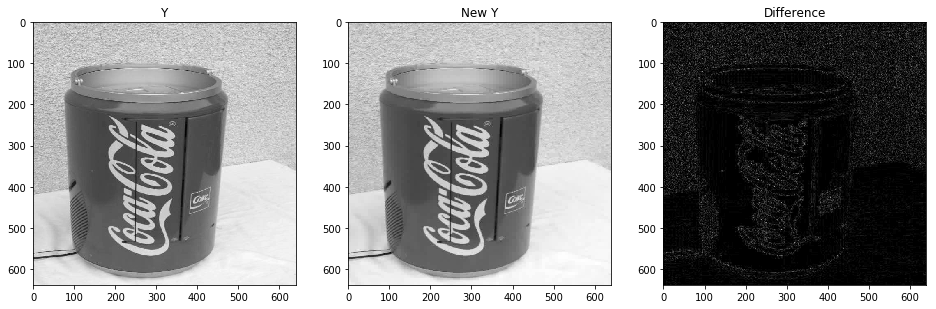

In [22]:
images = [ycbcr[:,:,0], newY, np.abs(ycbcr[:,:,0] - newY) ]
titles = ['Y','New Y','Difference']

display_images(images, titles)

### Answer for 1.4

New Y is not perceptibly different from Y. Both appear almost the same to the eye.
However, as (Y – NewY) shows that quite some details have been removed from the original image in the compressed version, most noticeably the writing on the can, it is safe to say that the quality has been degraded during compression. And further inspection with higher compression factors of w = 8 even shows some visible artifacts in New Y.

Subsampling in the chroma channels in both x and y directions by a factor of 4 allows us to have a lossy compression resulting in good quality, as the human visual system is quite tolerant of spatial imprecisions in the chroma channels (both Cb and Cr), but is not tolerant of imprecisions in the luma channel. The application of blockwise DCT to the Y channel and the subsampled Cb, Cr channels results in a block matrix of 64 DCT coefficients which allows us to safely identify and later remove coefficients that correlate to higher frequencies, as the human eye is not very sensitive to errors in high frequencies. DCT in itself itself is lossless. This is followed by quantisation which determines the final visual quality of the compressed image. This step is lossy since we use rounding. Finally, higher frequencies are quantised in a coarser way, generally depending on the final desired compression quality. 

Yes, we do lose quality, but the steps carried out for the compression result in a lossy compressed image with low perceptible loss of quality provided we do not compress the chroma channels by a large factor.

# 1.5 Encoding

In [23]:
# ! pip install dahuffman

In [24]:
def encodemat(imgChannel):
    
    key, counts = np.unique(imgChannel, return_counts = True)
    dic = {key[i]: counts[i] for i in range(len(key)) }
    
    codec = HuffmanCodec.from_frequencies(dic)
    encoded = codec.encode(imgChannel.flatten())
    
    return encoded, codec, imgChannel.shape

In [25]:
def decodemat(encodedImgChannel, codec, shape):
    
    decoded = codec.decode(encodedImgChannel)
    decoded = np.array(decoded)
    
    return decoded.reshape(shape)

In [35]:
encoded_y, codec_y, shape_y = encodemat(y_dash)
encoded_cb, codec_cb, shape_cb = encodemat(cb_dash)
encoded_cr, codec_cr, shape_cr = encodemat(cr_dash)

In [37]:
# Lengths of the encoded channels:

print(len(encoded_y))
print(len(encoded_cb))
print(len(encoded_cr))

66783
3583
3948


### Answer for 1.5

Lengths of the encoded channels:
1. Y’ => 66783
2. Cb’ => 3583
3. Cr’ => 3948

# 1.6 Decompression

## 1.6.1 Compression 
Done again just to help easily find variables for decompression

In [29]:
colaImage = Image.open("cola.jpg")
colaImageMat = np.array(colaImage)

# Factor of compression
w = 4  

In [30]:
# Converting to ycbcr color space
ycbcr = colortrans(colaImageMat)

# Downsampling the chroma channels cb and cr
y = ycbcr[:,:,0]
cb_down = downsample(ycbcr[:,:,1],w)
cr_down = downsample(ycbcr[:,:,2],w)

# Applying 8*8 DCT and quantizing each block
y_dash = dct_quant(y)
cb_dash = dct_quant(cb_down) #dct_quant(ycbcr[:,:,2])#
cr_dash = dct_quant(cr_down) #dct_quant(ycbcr[:,:,2])#

# Applying lossless Huffman Encoding to each of the channels
encoded_y, codec_y, shape_y = encodemat(y_dash)
encoded_cb, codec_cb, shape_cb = encodemat(cb_dash)
encoded_cr, codec_cr, shape_cr = encodemat(cr_dash)

## 1.6.2 Decompression

In [32]:
# Applying lossless Huffman Decoding to each of the channels
decoded_y = decodemat(encoded_y, codec_y, shape_y)
decoded_cb = decodemat(encoded_cb, codec_cb, shape_cb)
decoded_cr = decodemat(encoded_cr, codec_cr, shape_cr)

# Applying 8*8 IDCT and inverese quantization on each block
newY = idct_iquant(decoded_y)
newCb = idct_iquant(decoded_cb)
newCr = idct_iquant(decoded_cr)

# Upsampling the chroma channels cb and cr
newCb = upsample(newCb, w)
newCr = upsample(newCr, w)

# Forming ycbcr image array
ycbcr_Array = np.zeros((shape_y[0],shape_y[1],3))
ycbcr_Array[..., 0] = newY[:]
ycbcr_Array[..., 1] = newCb[:]
ycbcr_Array[..., 2] = newCr[:]

# Converting to rgb color space
rgb_Array = invcolortrans(ycbcr_Array)

# Clipping to ensure all intensities are within range
rgb_Array = np.clip(rgb_Array,0, 255)

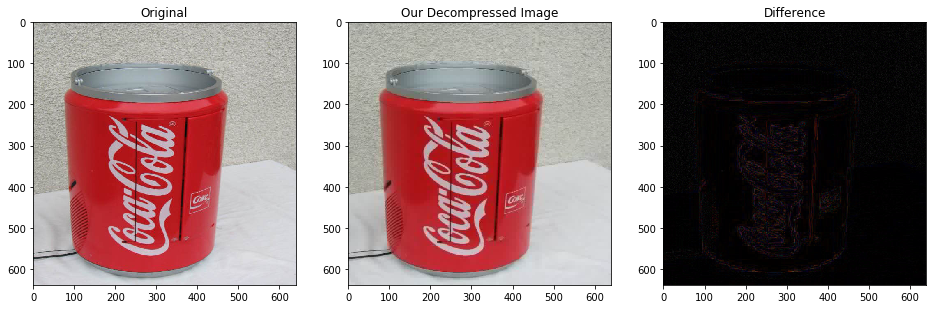

In [33]:
images = [colaImageMat, rgb_Array, np.abs(colaImageMat - rgb_Array) ]
titles = ["Original", "Our Decompressed Image", "Difference"]

display_images(images, titles)

### Answer for 1.6

The quality here is reduced due to the loss in information resulting from subsampling of Chroma channels and quantisation of DCT coefficients. While subsampling, the grey values in each block are replaced by the mean grey value for the block, thus reducing high frequency details in the Chroma channels. Later, after performing DCT, the DCT coefficients are divided by using the entries of the quantisation matrix and the resulting values are rounded off. This is again lossy.

In [34]:
# images = [colaImageMat, rgb_Array, np.abs(colaImageMat - rgb_Array) ]

# fig=plt.figure(figsize=(16, 16))

# columns = 3
# rows = 1
# for i in range(1, 4):
    
#     fig.add_subplot(rows, columns, i)
#     plt.imshow(images[i-1].astype(np.uint8))
#     plt.imsave(str(i)+".png", images[i-1].astype(np.uint8))
# plt.show()